In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date, timedelta
from pprint import pprint

import pymc as pm

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.dates import DateRange, SeasonRange
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
logistic_curve = LogisticIncidenceCurve()
logistic_curve

In [3]:
logistic_curve.parameters

('m', 'r', 's')

In [4]:
season_ranges = [
    SeasonRange(
        season="2022/2023", start_date=date(2022, 9, 5), end_date=date(2023, 4, 30)
    ),
    SeasonRange(
        season="2023/2024", start_date=date(2023, 9, 4), end_date=date(2024, 4, 28)
    ),
]
date_ranges = []
for season_range in season_ranges:
    start_date = season_range.start_date
    while start_date < season_range.end_date:
        end_date = start_date + timedelta(days=6)
        date_ranges.append(
            DateRange(
                season=season_range.season,
                start_date=start_date,
                end_date=end_date,
                report_date=end_date,
            )
        )
        start_date += timedelta(days=7)

In [5]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 0.5, "sigma": 0.1},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=0.15,
            mu=0.0,
            sigma=0.015,
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[0.1, 0.2],
            mu=[0.0, 0.0],
            sigma=[0.015, 0.015],
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.25, "sigma": 0.25},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 45.0, "sigma": 2.0},
        ),
    ],
    covariate_categories=[
        CovariateCategories(covariate="sex", categories=("female", "male")),
        CovariateCategories(covariate="age", categories=("youth", "adult", "senior")),
    ],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    name="Test Model",
)
model

In [6]:
pprint(model.coordinates())

{'covariate_age_categories': ['youth', 'adult', 'senior'],
 'covariate_age_categories_limited': ['adult', 'senior'],
 'covariate_names': ['sex', 'age'],
 'covariate_sex_categories': ['female', 'male'],
 'covariate_sex_categories_limited': ['male'],
 'parameters': ['m', 'r', 's'],
 'season': ['2022/2023', '2023/2024'],
 'season_2022_2023_dates': ['2022-09-05',
                            '2022-09-06',
                            '2022-09-07',
                            '2022-09-08',
                            '2022-09-09',
                            '2022-09-10',
                            '2022-09-11',
                            '2022-09-12',
                            '2022-09-13',
                            '2022-09-14',
                            '2022-09-15',
                            '2022-09-16',
                            '2022-09-17',
                            '2022-09-18',
                            '2022-09-19',
                            '2022-09-20',
        

In [7]:
model.build(debug=True)

INFO: Using 68 date ranges for the uptake model.
ERROR: No observations were provided, will not be able to calibrate model only sample from prior.
INFO: Added season 2022/2023 to the model with 238 days.
INFO: Added season 2023/2024 to the model with 238 days.
INFO: Added covariate MSeason to the model.
INFO: Added covariate MSex to the model.
INFO: Added covariate MAge to the model.
INFO: Added covariate RSeason to the model.
INFO: Added covariate SSeason to the model.
INFO: Added summed parameter MSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter RSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter SSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter MSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter RSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter SSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter MSeason20222023SexFemaleAgeAdult to the 

In [8]:
model._model

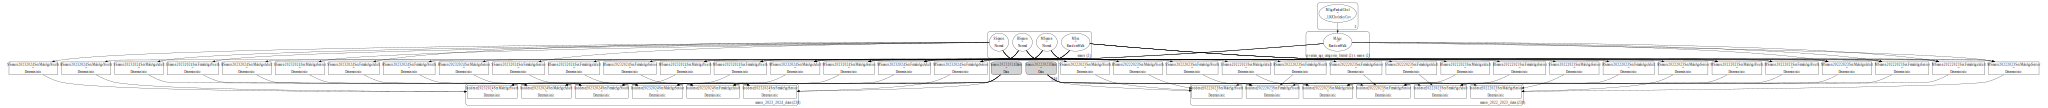

In [9]:
pm.model_to_graphviz(model._model)